#Salarios en Ciencia de Datos

###Objetivo
Queremos crear una predicción sobre los posibles salarios que deberían pagar las empresas que están en búsquedas laborales para este rubro, de acuerdo a determinadas características.


###Contexto comercial

Dadas las condiciones actuales de oferta y demanda en el mercado laboral de la Ciencia de datos, somos una consultora que se dedica a la determinación de valores de salarios y queremos generar un proyecto que determine de la manera más realista posible los de Salarios en el área de Ciencia de Datos y sus características determinantes.


###Hipótesis/Preguntas de Interes

Nuestra tarea entonces es encontrar y manipular datos disponibles para poder respondernos preguntas, encontrar relaciones, información y luego ganar la capacidad de generar predicciones. Entonces nos preguntamos:

cómo ha fluctuado el salario en empleos de Ciencia de Datos en los últimos tiempos?

El trabajo remoto influye a la hora de determinar salarios?

Las empresas de mayor tamaño pagan mayores salarios?

El país de residencia del empleado genera algún tipo de influencia sobre la determinación del salario?

La ubicación de la Casa Central de la empresa, determina algún tipo de condición a la hora de determinar salarios?

Las distintas especializaciones en Ciencia de datos, son, de alguna manera similarmente remuneradas?

La forma de contratación es determinante a la hora de negociar salario?

Es influyente el nivel de experiencia?


###Contexto analítico

Recurrimos a un archivo .CSV de la página Kaggle que contiene información sobre Salarios en Ciencia de Datos desde 2020 hasta 2023. Se agregan columnas extras de interés, generadas en un trabajo previo sobre el mismo tema, para poder anclar a una moneda y a un valor real los salarios, y se realizan modificaciones sobre los nombres de determinados registros para facilitar la lectura de los resultados. Consecutivamente preparamos los datos para poder crear visualizaciones, realizar análisis y construir modelos de predicción. Se utilizará un modelo analítico supervisado con un algoritmo de regresión para poder crear predicciones sobre valores de salarios de acuerdo a determinadas características tales como: forma de trabajo, tipo de empleo, lugar de residencia, tamaño de la empresa, título del potencial empleado, nivel de experiencia.

In [3]:
#importamos librerias
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.stats import norm

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.pipeline import Pipeline

In [4]:
#conectamos con drive
from google.colab import drive
drive.mount ('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
#traemos el df a analizar
df= pd.read_csv('/content/drive/MyDrive/Data Science- Coder/Data_Storytelling+Eschbach/ds_salaries.csv')

In [5]:
#mostramos la cantidad de registros
df.shape

(3755, 11)

In [6]:
#chequeamos valores nulos
df.isnull().values.any()

False

In [7]:
#mostramos columnas
df.columns

Index(['work_year', 'experience_level', 'employment_type', 'job_title',
       'salary', 'salary_currency', 'salary_in_usd', 'employee_residence',
       'remote_ratio', 'company_location', 'company_size'],
      dtype='object')

**El dataframe contiene 11 columnas, cada una de las cuales son:**

work_year: El año en que se pagó el salario.

experience_level: El nivel de experiencia en el trabajo durante el año

employment_type: El tipo de empleo (FL:full time, FP:Part time, CT:Contratado, FL:Free Lancer)

job_title: denominación del puesto de trabajo en el que se trabajó durante el año.

salary: El monto total del salario bruto pagado.

salary_currency: La moneda del salario pagado como un código de moneda ISO 4217.

salary_in_usd: El salario en USD

employee_residence: País de residencia principal del empleado durante el año laboral como código de país ISO 3166.

remote_ratio: la cantidad total de trabajo realizado de forma remota

company_location: El país de la oficina principal del empleador o sucursal contratante

company_size: La mediana del número de personas que trabajaron para la empresa durante el año



In [9]:
df.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,L
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,S
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,S
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,M
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,CA,M


In [8]:
#chequeamos los tipos de datos para ver qué uso podemos darle en el análisis
df.dtypes

work_year              int64
experience_level      object
employment_type       object
job_title             object
salary                 int64
salary_currency       object
salary_in_usd          int64
employee_residence    object
remote_ratio           int64
company_location      object
company_size          object
dtype: object

In [10]:
#incluimos una nube de palabras, importamos libreria
from wordcloud import WordCloud


In [11]:
textos= ''. join(df['job_title'])

In [12]:
wordcloud= WordCloud(width=800, height=400, background_color='white').generate(textos)

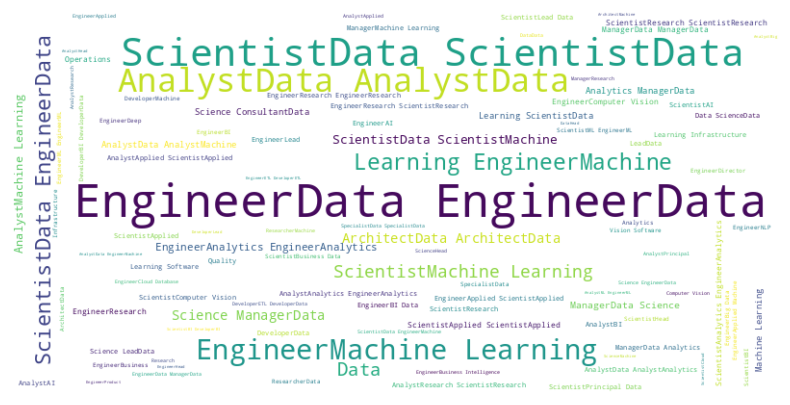

In [13]:
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


#Analisis Exploratorio de Datos

### Indexamos los salarios de acuerdo a la inflación para poder tomar los salarios reales.

Se definen las tasas de inflación para los Estados Unidos (EE. UU.) y los mercados globales. Estas tasas se utilizarán para ajustar los salarios en función del año y la moneda.

Se creó una función adjust_salary() que tome una fila del conjunto de datos como entrada y calcule el salario ajustado en función del año laboral, el salario original y la moneda. Si el año laboral es 2023, no es necesario ajustar el salario y se devuelve el salario original.

Se determinó el número de años entre el año laboral y 2023 . Se utilizó la tasa de inflación adecuada en función de la moneda, ya sea la tasa de inflación global o de EE. UU.

Se calculó el salario ajustado aplicando la tasa de inflación al salario original para cada año desde el año laboral hasta 2023.

Se aplicó la función adjust_salary() al conjunto de datos utilizando el método apply() y se creó una nueva columna 'adjusted_salary' con los valores salariales ajustados.

Al tener en cuenta la inflación, podemos obtener una mejor comprensión del valor real de los salarios en diferentes años y monedas.



In [9]:
# Inflation rates
us_inflation_rates = {2019: 0.0181, 2020: 0.0123, 2021: 0.0470, 2022: 0.065}
global_inflation_rates = {2019: 0.0219, 2020: 0.0192, 2021: 0.0350, 2022: 0.088}

# Function to adjust salary
def adjust_salary(row):
    year = row['work_year']
    original_salary = row['salary_in_usd']
    currency = row['salary_currency']

    if year == 2023:
        return original_salary

    adjusted_salary = original_salary
    for y in range(year, 2023):
        if currency == 'USD':
            inflation_rate = us_inflation_rates[y]
        else:
            inflation_rate = global_inflation_rates[y]

        adjusted_salary *= (1 + inflation_rate)

    return adjusted_salary

# Apply the function to the dataset
df['adjusted_salary'] = df.apply(adjust_salary, axis=1)

Categorizamos en ramas de Ciencia de Datos de acuerdo al puesto de trabaajo ocupado (job_title)

In [10]:
def assign_broader_category(job_title):
    data_engineering = ["Business Intelligence Engineer", "Big Data Engineer", "Azure Data Engineer", "Data Engineer", "Analytics Engineer", "BI Developer", "Business Intelligence Engineer", "BI Data Engineer", "Cloud Database Engineer","Cloud Data Engineer", "Data Engineer","Data DevOps Engineer", "Data Infrastructure Engineer", "Data Operations Engineer", "Deep Learning Engineer", "ETL Engineer", "Lead Data Engineer", "Research Engineer", "Principal Data Engineer", "Marketing Data Engineer"]
    data_scientist = ["Data Science Consultant", "Data Science Engineer", "Director of Data Science", "Data Science Lead", "Data Scientist Lead", "Head of Data Science", "Data Science Manager", "Data Scientist", "Research Scientist", "Deep Learning Researcher", "Applied Data Scientist", "Data Science Tech Lead", "Lead Data Scientist", "Principal Data Scientist", "Staff Data Scientist", "Product Data Scientist"]
    machine_learning = ["Machine Learning Engineer", "Head of Machine Learning", "ML Engineer", "Lead Machine Learning Engineer", "Principal Machine Learning Engineer", "Applied Machine Learning Engineer", "Applied Machine Learning Scientist","Machine Learning Developer","Machine Learning Infrastructure Engineer", "Machine Learning Manager","Machine Learning Research Engineer", "Machine Learning Scientist", "Machine Learning Software Engineer", "ML Engineer", "Machine Learning Researcher"]
    data_architecture = ["Data Architect", "Big Data Architect", "Cloud Data Architect", "Principal Data Architect"]
    data_analytics = ["Data Analyst", "Data Analytics Consultant", "Data Analytics Engineer", "Data Analytics Lead", "Data Analytics Specialist", "BI Data Analyst", "Business Data Analyst","BI Analyst", "Compliance Data Analyst",  "Financial Data Analyst", "Finance Data Analyst", "Lead Data Analyst", "Staff Data Analyst", "Product Data Analyst", "Marketing Data Analyst", "Principal Data Analyst",  "Data Analytics Manager"]

    if job_title in data_engineering:
        return "Data Engineering"
    elif job_title in data_scientist:
        return "Data Science"
    elif job_title in machine_learning:
        return "Machine Learning"
    elif job_title in data_architecture:
        return "Data Architecture"
    elif job_title in data_analytics:
        return "Data_analytics"
    else:
        return "Other"

In [11]:
df['job_category'] = df['job_title'].apply(assign_broader_category)

In [12]:
#mostramos DF final
df.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size,adjusted_salary,job_category
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,L,85847.0,Data Science
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,S,30000.0,Machine Learning
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,S,25500.0,Machine Learning
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,M,175000.0,Data Science
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,CA,M,120000.0,Data Science


In [13]:
#mostramos valores generales de las variables numericas
df.describe().T

,count,mean,std,min,25%,50%,75%,max
work_year,3755.0,2022.373635,0.691448,2020.000,2022.0,2022.0,2023.0,2.023000e+03
salary,3755.0,190695.571771,671676.500508,6000.000,100000.0,138000.0,180000.0,3.040000e+07
salary_in_usd,3755.0,137570.389880,63055.625278,5132.000,95000.0,135000.0,175000.0,4.500000e+05
remote_ratio,3755.0,46.271638,48.589050,0.000,0.0,0.0,100.0,1.000000e+02
adjusted_salary,3755.0,142445.659208,64701.591333,5583.616,100000.0,139000.0,181050.0,5.079466e+05


In [18]:
max= df.salary_in_usd.max()
min= df.salary_in_usd.min()
print(max)
print(min)

450000
5132


De dicho análisis podemos observar, de manera genérica, que el salario promedio en dólares para empleos en Ciencia de Datos es de USD 137570 bruto anual, con una desviación estandar cercana al 45%, siendo que el 50% de los trabajadores ganan USD 135000 dólares anuales o menos.
En salarios reales, el salario promedio es de USD 142445 dólares anuales con una desviación estándar también del 45% sobre el valor medio.

Buscamos respuesta ahora a nuestra primera pregunta sobre cuál fue la evolución de los salarios en los últimos años

In [19]:
evolucion= df.groupby('work_year')['salary_in_usd','adjusted_salary'].mean().round(1)
print(evolucion)

           salary_in_usd  adjusted_salary
work_year                                
2020             92302.6         104710.5
2021             94087.2         105225.6
2022            133338.6         142233.9
2023            149045.5         149045.5


<ipython-input-19-4f4dbf11cbcd>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  evolucion= df.groupby('work_year')['salary_in_usd','adjusted_salary'].mean().round(1)


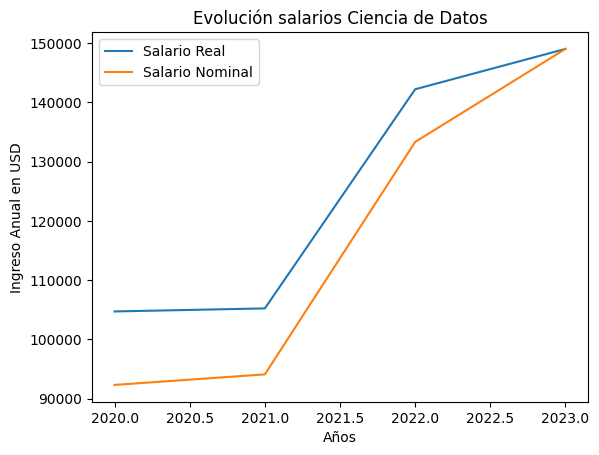

In [20]:
evolucion_real = evolucion['adjusted_salary']
evolucion_nominal = evolucion['salary_in_usd']
fig, ax = plt.subplots()
ax.plot(evolucion_real, label='Salario Real')
ax.plot(evolucion_nominal, label='Salario Nominal')
plt.legend()
plt.title('Evolución salarios Ciencia de Datos')
plt.xlabel('Años')
plt.ylabel('Ingreso Anual en USD')
plt.show()

Los salarios vienen en aumento desde 2020, pero muestra un gran salto desde principios de 2021 a inicios de 2022. Dada esta información parcial chequeamos la cantidad de datos que tenemos de acuerdo a los períodos para verificar si la distorsión tambien puede ser causada por este factor.

In [21]:
df.work_year.value_counts()

2023    1785
2022    1664
2021     230
2020      76
Name: work_year, dtype: int64

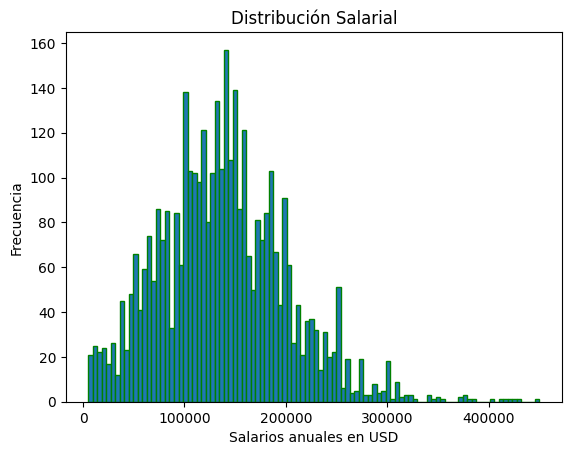

In [22]:
plt.hist(data=df, x='salary_in_usd', bins=100, edgecolor='green')
plt.title('Distribución Salarial')
plt.xlabel('Salarios anuales en USD')
plt.ylabel('Frecuencia')
plt.show()

Como es usual, los salarios poseen una asimetría positiva, o hacia la derecha, reconociendo mayor cantidad de salarios por debajo de la media que salarios altos.

Modificamos los tipos de datos del df para proceder a un análisis acorde.

In [23]:
df.dtypes

work_year               int64
experience_level       object
employment_type        object
job_title              object
salary                  int64
salary_currency        object
salary_in_usd           int64
employee_residence     object
remote_ratio            int64
company_location       object
company_size           object
adjusted_salary       float64
job_category           object
dtype: object

In [24]:
df['remote_ratio']= df['remote_ratio'].astype(str)
print(df.dtypes)

work_year               int64
experience_level       object
employment_type        object
job_title              object
salary                  int64
salary_currency        object
salary_in_usd           int64
employee_residence     object
remote_ratio           object
company_location       object
company_size           object
adjusted_salary       float64
job_category           object
dtype: object


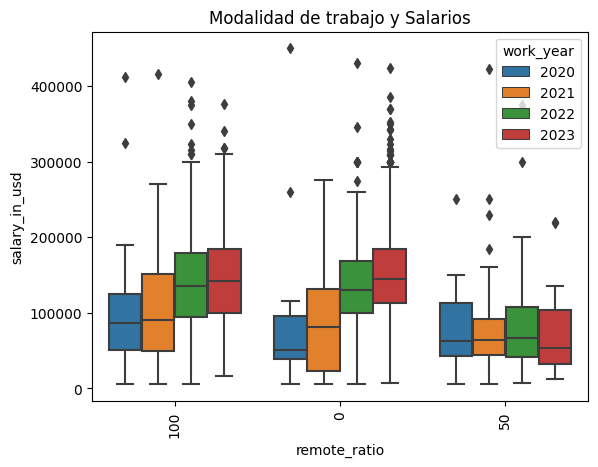

In [26]:
sns.boxplot(data=df, x='remote_ratio', y='salary_in_usd', hue='work_year')
plt.title('Modalidad de trabajo y Salarios')
plt.xticks(rotation=90)
plt.show()

In [28]:
df.groupby('remote_ratio').salary_in_usd.mean()

remote_ratio
0      144316.202288
100    136481.452830
50      78400.687831
Name: salary_in_usd, dtype: float64

In [27]:
df.groupby('remote_ratio').salary_in_usd.median()

remote_ratio
0      139600.0
100    135000.0
50      63312.0
Name: salary_in_usd, dtype: float64

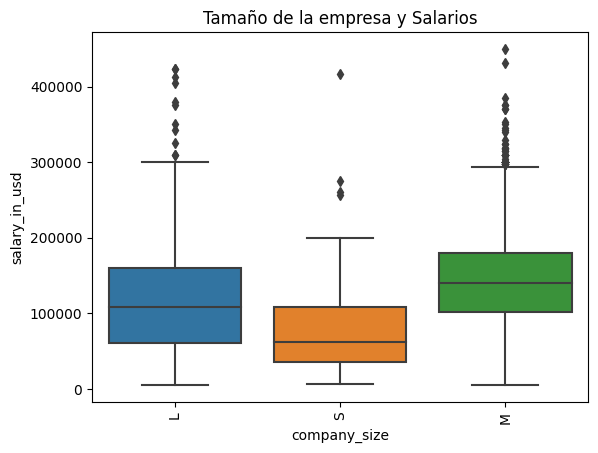

In [29]:
sns.boxplot(data=df, x='company_size', y='salary_in_usd')
plt.title('Tamaño de la empresa y Salarios')
plt.xticks(rotation=90)
plt.show()

In [30]:
df.groupby('company_size').salary_in_usd.mean()

company_size
L    118300.982379
M    143130.548367
S     78226.682432
Name: salary_in_usd, dtype: float64

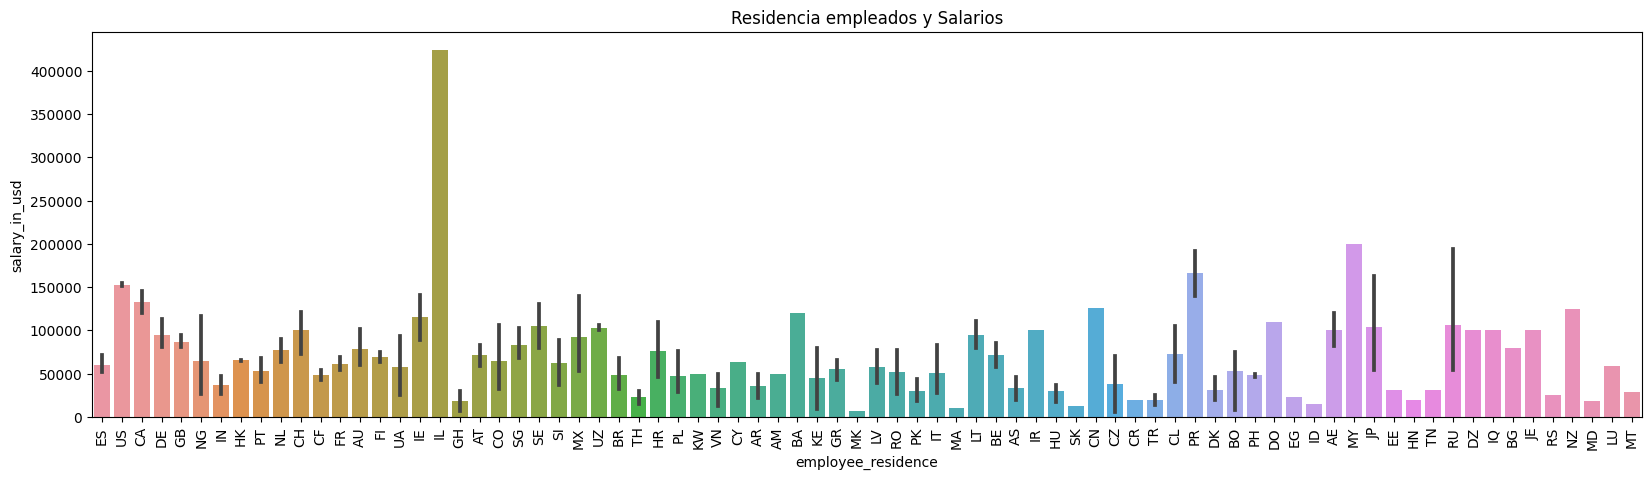

In [ ]:
plt.figure(figsize=(20,5))
sns.barplot(data=df, x='employee_residence', y='salary_in_usd')
plt.title('Residencia empleados y Salarios')
plt.xticks(rotation=90)
plt.show()

In [1]:
mayor_salario= df['salary_in_usd'].max()
fila_max= df.loc[df['salary_in_usd']==mayor_salario]
pais_residencia= fila_max['employee_residence'].values[0]

print('Mayor salario=', mayor_salario)
print('País de residencia de mayor salario:', pais_residencia)


NameError: ignored

En este caso vemos una discordancia entre lo que muestra el gráfico que da el país con mayor salario, Israel, pero de acuerdo a la base de datos vemos que el valor máximo de salario se da en un empleado con residencia en USA.

In [ ]:
promedios= df.groupby('employee_residence').salary_in_usd.median().sort_values()
print(promedios)

employee_residence
MK      6304.0
MA     10000.0
SK     12608.0
ID     15000.0
MD     18000.0
        ...   
CN    125404.0
US    145000.0
PR    160000.0
MY    200000.0
IL    423834.0
Name: salary_in_usd, Length: 78, dtype: float64


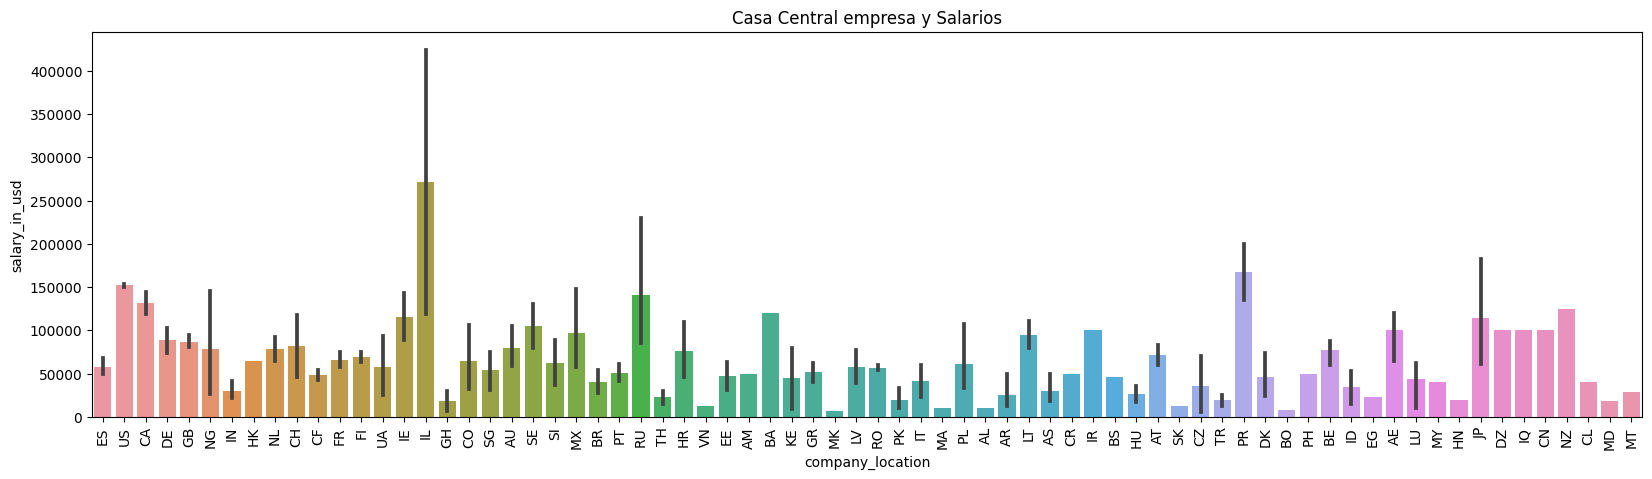

In [ ]:
plt.figure(figsize=(20,5))
sns.barplot(df, x='company_location', y='salary_in_usd')
plt.title('Casa Central empresa y Salarios')
plt.xticks(rotation=90)
plt.show()

In [ ]:
mayor_salario= df['salary_in_usd'].max()
fila_max= df.loc[df['salary_in_usd']==mayor_salario]
casa_central= fila_max['company_location'].values[0]

print('Mayor salario=', mayor_salario)
print('Ubicacion Casa Central de la empresa', casa_central)

Mayor salario= 450000
Ubicacion Casa Central de la empresa US


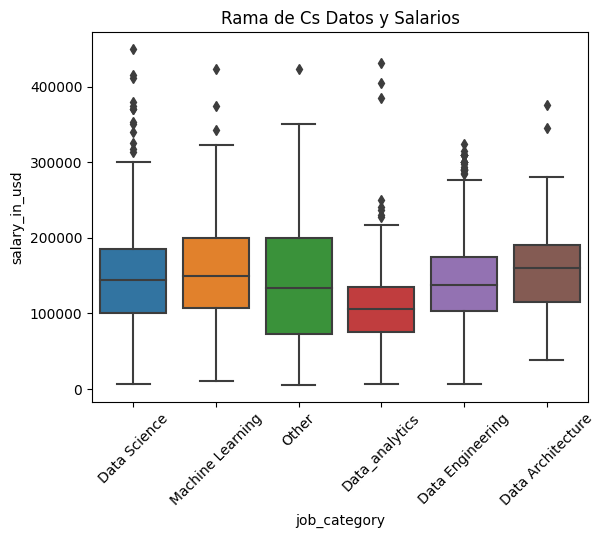

In [ ]:
sns.boxplot(data=df, x='job_category', y='salary_in_usd')
plt.title('Rama de Cs Datos y Salarios')
plt.xticks(rotation=45)
plt.show()

In [ ]:
df.groupby('job_category').salary_in_usd.mean().sort_values()

job_category
Data_analytics       106767.153191
Other                137278.537383
Data Engineering     142761.531949
Data Science         144545.700000
Machine Learning     150743.709046
Data Architecture    160693.809524
Name: salary_in_usd, dtype: float64

In [ ]:
df.groupby('job_category').salary_in_usd.median().sort_values()

job_category
Data_analytics       105380.0
Other                134000.0
Data Engineering     137197.0
Data Science         144000.0
Machine Learning     148800.0
Data Architecture    159500.0
Name: salary_in_usd, dtype: float64

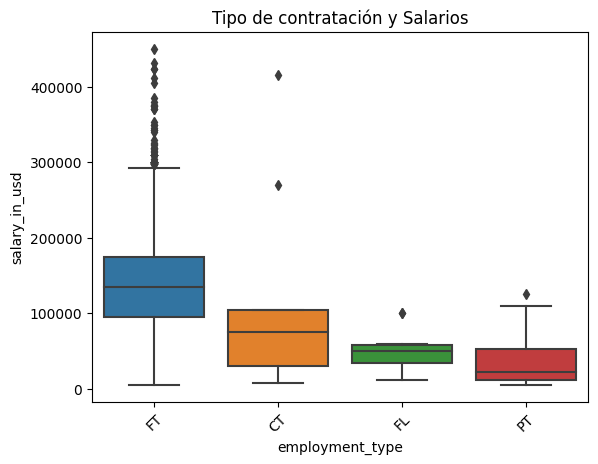

In [ ]:
sns.boxplot(data=df, x='employment_type', y='salary_in_usd')
plt.title('Tipo de contratación y Salarios')
plt.xticks(rotation=45)
plt.show()

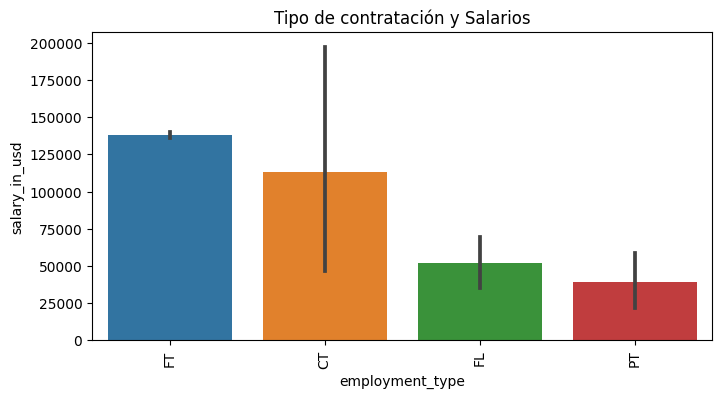

In [7]:
plt.figure(figsize=(8,4))
sns.barplot(df, x='employment_type', y='salary_in_usd')
plt.title('Tipo de contratación y Salarios')
plt.xticks(rotation=90)
plt.show()

In [ ]:
df.groupby('employment_type').salary_in_usd.mean().sort_values()

employment_type
PT     39533.705882
FL     51807.800000
CT    113446.900000
FT    138314.199570
Name: salary_in_usd, dtype: float64

In [ ]:
df.groupby('employment_type').salary_in_usd.median().sort_values()

employment_type
PT     21669.0
FL     50000.0
CT     75000.0
FT    135000.0
Name: salary_in_usd, dtype: float64

In [8]:
df.groupby('employment_type').salary_in_usd.max().sort_values()

employment_type
FL    100000
PT    125404
CT    416000
FT    450000
Name: salary_in_usd, dtype: int64

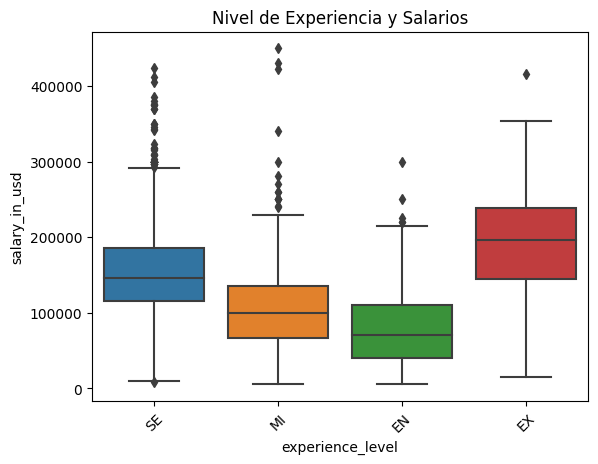

In [ ]:
sns.boxplot(data=df, x='experience_level', y='salary_in_usd')
plt.title('Nivel de Experiencia y Salarios')
plt.xticks(rotation=45)
plt.show()

In [ ]:
df.groupby('experience_level').salary_in_usd.mean().sort_values()

experience_level
EN     78546.284375
MI    104525.939130
SE    153051.071542
EX    194930.929825
Name: salary_in_usd, dtype: float64

In [ ]:
df.groupby('experience_level').salary_in_usd.median().sort_values()

experience_level
EN     70000.0
MI    100000.0
SE    146000.0
EX    196000.0
Name: salary_in_usd, dtype: float64